# Fruits Classification Model

## Transfer Learning

# Download the Fuits Datasets from web

!wget https://dsserver-prod-resources-1.s3.amazonaws.com/cnn/fruits_dataset.tar.gz

# Uncompress the datasets

import tarfile

def extract_tar_gz(file_path, extract_dir):
    with tarfile.open(file_path, 'r:gz') as tar:
        tar.extractall(path=extract_dir)

extract_tar_gz("/kaggle/working/fruits_dataset.tar.gz", '/kaggle/working')

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

# Loading the Dataset

In [2]:
from tensorflow.keras.utils import image_dataset_from_directory

train_set = image_dataset_from_directory(directory= "/kaggle/working/fruits/train",
                                labels= "inferred", label_mode = "categorical", batch_size = 256,
                                image_size = (100,100), validation_split = 0.25,
                                subset = "training", seed = 417)

validation_set = image_dataset_from_directory(directory= "/kaggle/working/fruits/train",
                                labels= "inferred", label_mode = "categorical", batch_size = 256,
                                image_size = (100,100), validation_split = 0.25,
                                subset = "validation", seed = 417)

test_set = image_dataset_from_directory(directory= "/kaggle/working/fruits/test",
                                labels= "inferred", label_mode = "categorical", batch_size = 256,
                                image_size = (100,100))

Found 67692 files belonging to 131 classes.
Using 50769 files for training.
Found 67692 files belonging to 131 classes.
Using 16923 files for validation.
Found 22688 files belonging to 131 classes.


In [3]:
# Rescaling an input

normalization_layer = tf.keras.layers.Rescaling(1/255)

train_set_normalized = train_set.map(lambda imgs, labels: (normalization_layer(imgs), labels))

validation_set_normalized = validation_set.map(lambda imgs, labels: (normalization_layer(imgs), labels))

test_set_normalized = test_set.map(lambda imgs, labels: (normalization_layer(imgs), labels))

# Loading in a Pre-Trained Model

In [4]:
from tensorflow.keras import applications

base_model = applications.resnet50.ResNet50(include_top = False,
                                           weights = "imagenet",
                                           input_shape = (100,100,3))

# Training the Model

In [5]:
# import the required libaries

from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import Model,Input

base_model.trainable = False

input_layer = Input(shape = (100,100,3))

# Preprocessing the Input

preprocessed_input_layer = applications.resnet50.preprocess_input(input_layer)
features_layer = base_model(preprocessed_input_layer, training = False)
global_pooling = GlobalAveragePooling2D()(features_layer)
output = Dense(131)(global_pooling)

model = Model(inputs=input_layer, outputs=output)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 100, 100)  │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 100, 100)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 100, 100)  │          0 │ input_layer_1[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 100, 100,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 100, 100,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 4, 4,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 131)       │    268,419 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,856,131 (91.00 MB)

 Trainable params: 268,419 (1.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [6]:
opt = tf.keras.optimizers.SGD()
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = ["accuracy"]

model.compile(optimizer = opt, loss = loss, metrics = metrics)
model.fit(train_set, epochs=3, validation_data=validation_set)

Epoch 1/3


I0000 00:00:1731579887.436702    1481 service.cc:145] XLA service 0x7e8510003730 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731579887.436767    1481 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731579887.436774    1481 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/199 ━━━━━━━━━━━━━━━━━━━━ 53:17 16s/step - accuracy: 0.0117 - loss: 6.2405

I0000 00:00:1731579895.342059    1481 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


199/199 ━━━━━━━━━━━━━━━━━━━━ 70s 273ms/step - accuracy: 0.3686 - loss: 3.2789 - val_accuracy: 0.9071 - val_loss: 0.7817
Epoch 2/3
199/199 ━━━━━━━━━━━━━━━━━━━━ 42s 211ms/step - accuracy: 0.9320 - loss: 0.6320 - val_accuracy: 0.9613 - val_loss: 0.4000
Epoch 3/3
199/199 ━━━━━━━━━━━━━━━━━━━━ 42s 211ms/step - accuracy: 0.9710 - loss: 0.3482 - val_accuracy: 0.9785 - val_loss: 0.2707


In [7]:
# Evaluation on Dataset

train_loss, train_acc = model.evaluate(train_set)
print('Train accuracy:', train_acc)

val_loss, val_acc = model.evaluate(validation_set)
print('Validation accuracy:', val_acc)

test_loss, test_acc = model.evaluate(test_set)
print('Test accuracy:', test_acc)

199/199 ━━━━━━━━━━━━━━━━━━━━ 33s 164ms/step - accuracy: 0.9813 - loss: 0.2605
Train accuracy: 0.981681764125824
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 0.9792 - loss: 0.2726
Validation accuracy: 0.9785498976707458
89/89 ━━━━━━━━━━━━━━━━━━━━ 19s 213ms/step - accuracy: 0.9136 - loss: 0.4801
Test accuracy: 0.9129495620727539


# Fine-tuning the Model

In [8]:
base_model.trainable = True

opt = tf.keras.optimizers.SGD(learning_rate=0.0001)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = ["accuracy"]

model.compile(optimizer = opt, loss = loss, metrics = metrics)
model.fit(train_set, epochs=5, validation_data=validation_set)

test_loss, test_acc = model.evaluate(test_set)
print('Test accuracy:', test_acc)

Epoch 1/5
199/199 ━━━━━━━━━━━━━━━━━━━━ 182s 721ms/step - accuracy: 0.5430 - loss: 2.1136 - val_accuracy: 0.7864 - val_loss: 1.1820
Epoch 2/5
199/199 ━━━━━━━━━━━━━━━━━━━━ 124s 625ms/step - accuracy: 0.6727 - loss: 1.6884 - val_accuracy: 0.7732 - val_loss: 1.3262
Epoch 3/5
199/199 ━━━━━━━━━━━━━━━━━━━━ 123s 621ms/step - accuracy: 0.7623 - loss: 1.4043 - val_accuracy: 0.8227 - val_loss: 1.1739
Epoch 4/5
199/199 ━━━━━━━━━━━━━━━━━━━━ 123s 620ms/step - accuracy: 0.8253 - loss: 1.1938 - val_accuracy: 0.8680 - val_loss: 1.0177
Epoch 5/5
199/199 ━━━━━━━━━━━━━━━━━━━━ 123s 620ms/step - accuracy: 0.8689 - loss: 1.0338 - val_accuracy: 0.8966 - val_loss: 0.8906
89/89 ━━━━━━━━━━━━━━━━━━━━ 15s 170ms/step - accuracy: 0.8221 - loss: 1.1210
Test accuracy: 0.8212270736694336


# Transfer Learning on the Beans Dataset I

In [10]:
b_train_set = tf.keras.utils.image_dataset_from_directory(
    directory= "/kaggle/input/beaaaans/beans/train",
    labels= "inferred", label_mode = "categorical", batch_size = 128,
    image_size = (100, 100),seed = 42)

b_validation_set = tf.keras.utils.image_dataset_from_directory(
    directory= "/kaggle/input/beaaaans/beans/validation",
    labels= "inferred", label_mode = "categorical", batch_size = 128,
    image_size = (100, 100), seed = 42)

b_test_set = tf.keras.utils.image_dataset_from_directory(
    directory= "/kaggle/input/beaaaans/beans/test",
    labels= "inferred", label_mode = "categorical", batch_size = 128,
    image_size = (100, 100),seed = 42)


Found 1034 files belonging to 3 classes.
Found 133 files belonging to 3 classes.
Found 128 files belonging to 3 classes.


In [11]:
base_model = applications.resnet50.ResNet50(include_top = False,
                                           weights = "imagenet",
                                           input_shape = (100,100,3))

In [12]:
base_model.trainable = False

input_layer = Input(shape = (100,100,3))

# Preprocessing the Input

preprocessed_input_layer = applications.resnet50.preprocess_input(input_layer)
augmentation_layer = tf.keras.layers.RandomFlip(mode="horizontal_and_vertical")(preprocessed_input_layer)
features_layer = base_model(augmentation_layer, training = False)
global_pooling = GlobalAveragePooling2D()(features_layer)
output = Dense(3)(global_pooling)

model = Model(inputs=input_layer, outputs=output)

opt = tf.keras.optimizers.Adam()
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = ["accuracy"]

model.compile(optimizer = opt, loss = loss, metrics = metrics)
history = model.fit(b_train_set, epochs=20, validation_data = b_validation_set, verbose = 0)

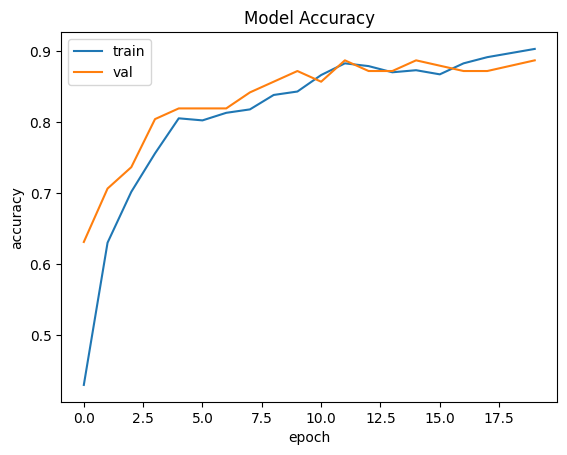

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

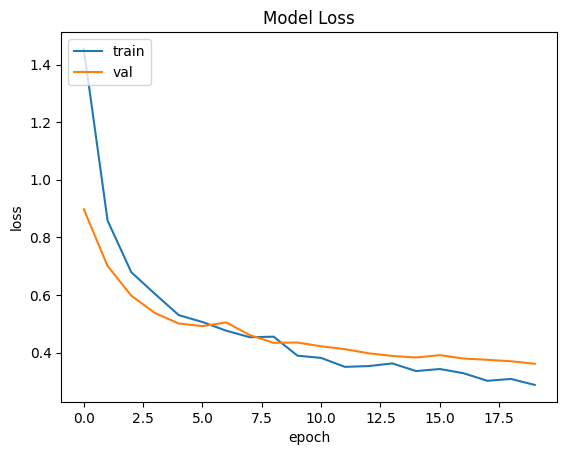

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [15]:
# Evaluation on Dataset

train_loss, train_acc = model.evaluate(b_train_set)
print('Train accuracy:', train_acc)

val_loss, val_acc = model.evaluate(b_validation_set)
print('Validation accuracy:', val_acc)

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 282ms/step - accuracy: 0.9017 - loss: 0.2709
Train accuracy: 0.9003868699073792
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8857 - loss: 0.3632 
Validation accuracy: 0.8872180581092834


# Transfer Learning on the Beans Dataset II

In [16]:
base_model.trainable = True

for layer in base_model.layers[:-10]:
    layer.trainable = False
    
    
opt = tf.keras.optimizers.Adam(learning_rate = 0.00001)
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = ["accuracy"]

model.compile(optimizer = opt, loss = loss, metrics = metrics)
history = model.fit(b_train_set, epochs=20, validation_data = b_validation_set, verbose = 0)

# Evaluation on Dataset

train_loss, train_acc = model.evaluate(b_train_set)
print('Train accuracy:', train_acc)

val_loss, val_acc = model.evaluate(b_validation_set)
print('Validation accuracy:', val_acc)

test_loss, test_acc = model.evaluate(b_test_set)
print('Test accuracy:', test_acc)

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 269ms/step - accuracy: 0.9504 - loss: 0.1823
Train accuracy: 0.957446813583374
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8884 - loss: 0.3223 
Validation accuracy: 0.8872180581092834
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.8906 - loss: 0.2967
Test accuracy: 0.890625


# Conclusion

We managed to get a test accuracy of **~89%** on our beans dataset.
However, higher taing and validation accuracies but a relatively low test accuracy can also be a sign of overfitting. Wecould always consider adding some regularization to our model to account for that possibility.